In [4]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np

In [5]:
iris = load_iris()
sepal_length = iris.data[:, 0]
petal_width = iris.data[:, 3]
target = iris.target

species_dict = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
species_name = [species_dict[i] for i in target]

In [6]:
b = 0
x = 0

# create a list of y values using list comprehension
y = [
    b + sepal_length[i] * x for i in range(len(sepal_length))
]

In [7]:
loss_history = list()
intercept_history = list()
coefficient_history = list()

def predict(intercept, coefficient, data):
    return intercept + np.dot(coefficient, data)

def loss_function(coefficient, errors, l1_penalty):
    return np.mean(np.square(errors)) + l1_penalty * np.sum(np.abs(coefficient))

def lasso_regression(x, y, epochs, learning_rate = 0.01, l1_penalty = 0.01):
    intercept, coefficient = 0, 0
    length = len(x)

    for _ in range(1, epochs):
        predictions = predict(intercept, coefficient, x)
        errors = predictions - y
        intercept = intercept - learning_rate * np.sum(errors) / length
        coefficient = coefficient - learning_rate * np.sum(errors * x) / length
        loss_history.append(loss_function(coefficient, errors, l1_penalty))
        intercept_history.append(intercept)
        coefficient_history.append(coefficient)

    return intercept, coefficient

b, x = lasso_regression(sepal_length, petal_width, 10000)
print(b, x)

-2.717366489030271 0.6718570469763597


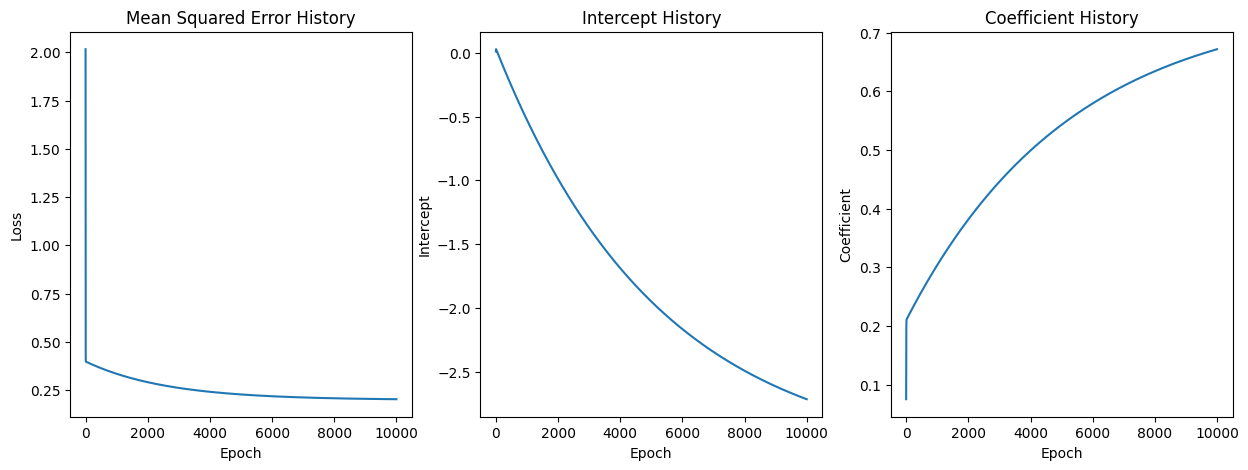

In [8]:
# create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# plot the loss history
ax1.plot(loss_history)
ax1.set_title('Mean Squared Error History')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# plot the intercept history
ax2.plot(intercept_history)
ax2.set_title('Intercept History')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Intercept')

# plot the coefficient history
ax3.plot(coefficient_history)
ax3.set_title('Coefficient History')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Coefficient')

plt.show()
